In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [3]:
print(f"There are {len(arxiv_data)} rows in the dataset.")


There are 51774 rows in the dataset.


In [4]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [5]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


In [6]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

In [7]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [8]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [9]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.SE', 'cs.NI', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'math.DS', 'quant-ph', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.ao-ph', 'physics.soc-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'hep-ex', '68T10', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'physics.optics', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.2.10; I.4;

In [10]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV']
Label-binarized representation: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]


In [11]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()


count    32985.000000
mean       156.536395
std         41.460921
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [12]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [13]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [14]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Reinforcement learning (RL) is widely used in autonomous driving tasks and\ntraining RL models typically involves in a multi-step process: pre-training RL\nmodels on simulators, uploading the pre-trained model to real-life robots, and\nfine-tuning the weight parameters on robot vehicles. This sequential process is\nextremely time-consuming and more importantly, knowledge from the fine-tuned\nmodel stays local and can not be re-used or leveraged collaboratively. To\ntackle this problem, we present an online federated RL transfer process for\nreal-time knowledge extraction where all the participant agents make\ncorresponding actions with the knowledge learned by others, even when they are\nacting in very different environments. To validate the effectiveness of the\nproposed approach, we constructed a real-life collision avoidance system with\nMicrosoft Airsim simulator and NVIDIA JetsonTX2 car agents, which cooperatively\nlearn from scratch to avoid collisions in indoor envir

In [15]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153229


In [16]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [17]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/20


I0000 00:00:1727010286.485726      98 service.cc:145] XLA service 0x7ea00c0cad70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727010286.486733      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/258 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - binary_accuracy: 0.6617 - loss: 0.5972

I0000 00:00:1727010287.959063      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - binary_accuracy: 0.9699 - loss: 0.0717 - val_binary_accuracy: 0.9941 - val_loss: 0.0187
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - binary_accuracy: 0.9985 - loss: 0.0048 - val_binary_accuracy: 0.9939 - val_loss: 0.0262
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - binary_accuracy: 0.9998 - loss: 9.3034e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0337
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - binary_accuracy: 0.9999 - loss: 3.5933e-04 - val_binary_accuracy: 0.9938 - val_loss: 0.0379
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - binary_accuracy: 1.0000 - loss: 1.9516e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0402
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - binary_accuracy: 1.0000 - loss: 1.1819e-04 - val_binary_accuracy: 0.9939 - val_loss: 0.0426
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - binary_accuracy: 1.0000 - loss: 1.0642e-04 - val_binary_accuracy: 0.9939 -

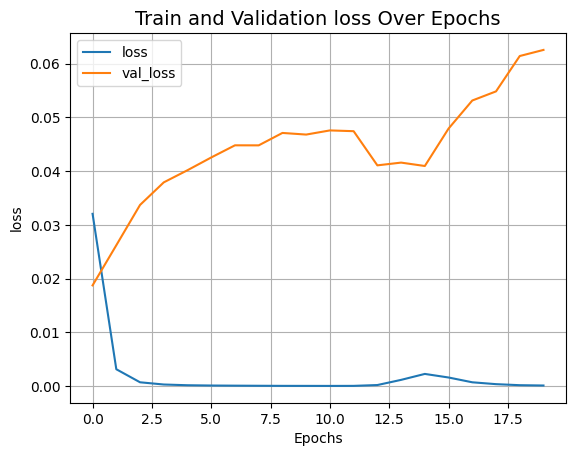

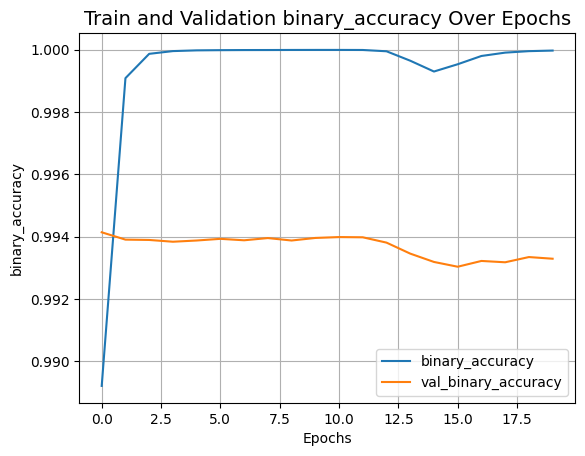

In [18]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [19]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.9932 - loss: 0.0629
Categorical accuracy on the test set: 99.31%.


In [20]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Abstract: b'Existing research shows that the batch size can seriously affect the\nperformance of stochastic gradient descent~(SGD) based learning, including\ntraining speed and generalization ability. A larger batch size typically\nresults in less parameter updates. In distributed training, a larger batch size\nalso results in less frequent communication. However, a larger batch size can\nmake a generalization gap more easily. Hence, how to set a proper batch size\nfor SGD has recently attracted much attention. Although some methods about\nsetting batch size have been proposed, the batch size problem has still not\nbeen well solved. In this paper, we first provide theory to show that a proper\nbatch size is related to the gap between initialization and optimum of the\nmodel parameter. Then based on this theory, we propose a novel method, called\n\\underline{s}tagewise \\underline{e}nlargement of \\underline{b}atch\n\\underline{s}ize~(\\mbox{SEBS}),